In [25]:
import pandas as pd
import numpy as np
from enum import IntEnum
import matplotlib.pyplot as plt

In [26]:
MODEL_NAME = "resnet_gtsrb_old_models"

In [27]:
class Patterns(IntEnum):
    SAME_FEATURE_MAP_SAME_ROW = 0
    SAME_FEATURE_MAP_SAME_COLUMN = 1
    SAME_FEATURE_MAP_BLOCK = 2
    SAME_FEATURE_MAP_RANDOM = 3
    MULTIPLE_FEATURE_MAPS_BULLET_WAKE = 4
    MULTIPLE_FEATURE_MAPS_BLOCK = 5
    MULTIPLE_FEATURE_MAPS_SHATTER_GLASS = 6
    MULTIPLE_FEATURE_MAPS_QUASI_SHATTER_GLASS = 7
    MULTIPLE_FEATURE_MAPS_UNCATEGORIZED = 8
    SKIP_4 = 1001
    CHANNEL_ALIGNED_BLOCKS = 1002
    TENSOR_ALIGNED_SINGLE_BLOCK = 1003
    SINGLE_BLOCK = 1004
    MULTI_CHANNEL_MULTI_BLOCK = 1005
    SHATTERED_CHANNEL = 1006
    QUASI_SHATTERED_CHANNEL = 1007
    SINGLE_CHANNEL_ALTERNATED_BLOCKS = 1008

In [28]:
def replacePatternNames(col):
    return col.map(Patterns())

In [29]:
data = pd.read_csv("pattern_" + MODEL_NAME + ".csv")

In [30]:
data

,Unnamed: 0,Mode,Layer_name,Sample_id,Cardinality,Pattern,Misprediction
0,0,FaultInjection,classes_conv1_conv,0,478,1005,1
1,1,FaultInjection,classes_conv1_conv,0,30,1004,1
2,2,FaultInjection,classes_conv1_conv,0,32,1004,1
3,3,FaultInjection,classes_conv1_conv,0,32,1004,1
4,4,FaultInjection,classes_conv1_conv,0,8,1001,1
...,...,...,...,...,...,...,...
476155,158715,Ranger_Ranger_Layer,classes_batch_normalization,9,32,1004,1
476156,158716,Ranger_Ranger_Layer,classes_batch_normalization,9,32,1004,1
476157,158717,Ranger_Ranger_Layer,classes_batch_normalization,9,32,1004,1
476158,158718,Ranger_Ranger_Layer,classes_batch_normalization,9,32,1004,1


In [31]:
grouped_data = data.groupby(by=["Layer_name","Mode","Pattern"]).agg({'Misprediction': ['count',np.sum]}).reset_index()
grouped_data["Fault_damage_level"] = (grouped_data['Misprediction']['sum'] /grouped_data['Misprediction']['count']) * 100
grouped_data["Fault_damage_level"] = grouped_data["Fault_damage_level"].round(1)
grouped_data = grouped_data.drop(columns=['Misprediction'])
grouped_data

/home/nicola/miniconda3/envs/nicola/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,Layer_name,Mode,Pattern,Fault_damage_level
,,,,
0,classes_batch_normalization,FaultInjection,1004,100.0
1,classes_batch_normalization,FaultInjection,1008,100.0
2,classes_batch_normalization,Ranger_Clipping_Layer,1004,8.8
3,classes_batch_normalization,Ranger_Clipping_Layer,1008,0.0
4,classes_batch_normalization,Ranger_Ranger_Layer,1004,96.4
...,...,...,...,...
1600,classes_pool1_pool,Ranger_Ranger_Layer,8,0.0
1601,classes_pool1_pool,Ranger_Ranger_Layer,1004,1.3
1602,classes_pool1_pool,Ranger_Ranger_Layer,1005,3.4


In [32]:
def getLayerReport(table,TARGET_LAYER):
    layer = table.loc[grouped_data['Layer_name'] == TARGET_LAYER]
    return layer

In [33]:
def processLayerReport(layer):
    layer_pattern_report = layer.pivot(index =['Layer_name','Pattern'], columns =['Mode'])["Fault_damage_level"].reset_index()
    layer_pattern_report= layer_pattern_report.drop(columns=['Layer_name'])

    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(-1,"RANDOM")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(0,"SAME_FEATURE_MAP_SAME_ROW")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1,"SAME_FEATURE_MAP_SAME_COLUMN")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(2,"SAME_FEATURE_MAP_BLOCK")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(3,"SAME_FEATURE_MAP_RANDOM")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(4,"MULTIPLE_FEATURE_MAPS_BULLET_WAKE")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(5,"MULTIPLE_FEATURE_MAPS_BLOCK")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(6,"MULTIPLE_FEATURE_MAPS_SHATTER_GLASS")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(7,"MULTIPLE_FEATURE_MAPS_QUASI_SHATTER_GLASS")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(8,"MULTIPLE_FEATURE_MAPS_UNCATEGORIZED")

    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1001,"SKIP_4")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1002,"CHANNEL_ALIGNED_BLOCKS")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1003,"TENSOR_ALIGNED_SINGLE_BLOCK")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1004,"SINGLE_BLOCK")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1005,"MULTI_CHANNEL_MULTI_BLOCK")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1006,"SHATTERED_CHANNEL")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1007,"QUASI_SHATTERED_CHANNEL")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1007,"SINGLE_CHANNEL_ALTERNATED_BLOCKS")

    layer_pattern_report = layer_pattern_report.set_index([ 'Pattern'])
    return layer_pattern_report

In [34]:
def getModelReport(model):
    classes_layers = grouped_data['Layer_name'].unique()
    reports = []
    for layer in classes_layers:
        print(f"Creating report for {layer}")
        l = getLayerReport(grouped_data,layer)
        l = processLayerReport(l)
        reports.append(l)

    return classes_layers,reports

In [35]:
classes_layers,reports = getModelReport(grouped_data)

Creating report for classes_batch_normalization
Creating report for classes_conv1_bn
Creating report for classes_conv1_conv
Creating report for classes_conv2_block1_0_bn
Creating report for classes_conv2_block1_0_conv
Creating report for classes_conv2_block1_1_bn
Creating report for classes_conv2_block1_1_conv


/home/nicola/miniconda3/envs/nicola/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Creating report for classes_conv2_block1_2_bn
Creating report for classes_conv2_block1_2_conv
Creating report for classes_conv2_block1_3_bn
Creating report for classes_conv2_block1_3_conv
Creating report for classes_conv2_block1_add
Creating report for classes_conv2_block2_1_bn
Creating report for classes_conv2_block2_1_conv
Creating report for classes_conv2_block2_2_bn
Creating report for classes_conv2_block2_2_conv
Creating report for classes_conv2_block2_3_bn
Creating report for classes_conv2_block2_3_conv
Creating report for classes_conv2_block2_add
Creating report for classes_conv2_block3_1_bn
Creating report for classes_conv2_block3_1_conv
Creating report for classes_conv2_block3_2_bn
Creating report for classes_conv2_block3_2_conv
Creating report for classes_conv2_block3_3_bn
Creating report for classes_conv2_block3_3_conv
Creating report for classes_conv2_block3_add
Creating report for classes_conv3_block1_0_bn
Creating report for classes_conv3_block1_0_conv
Creating report for

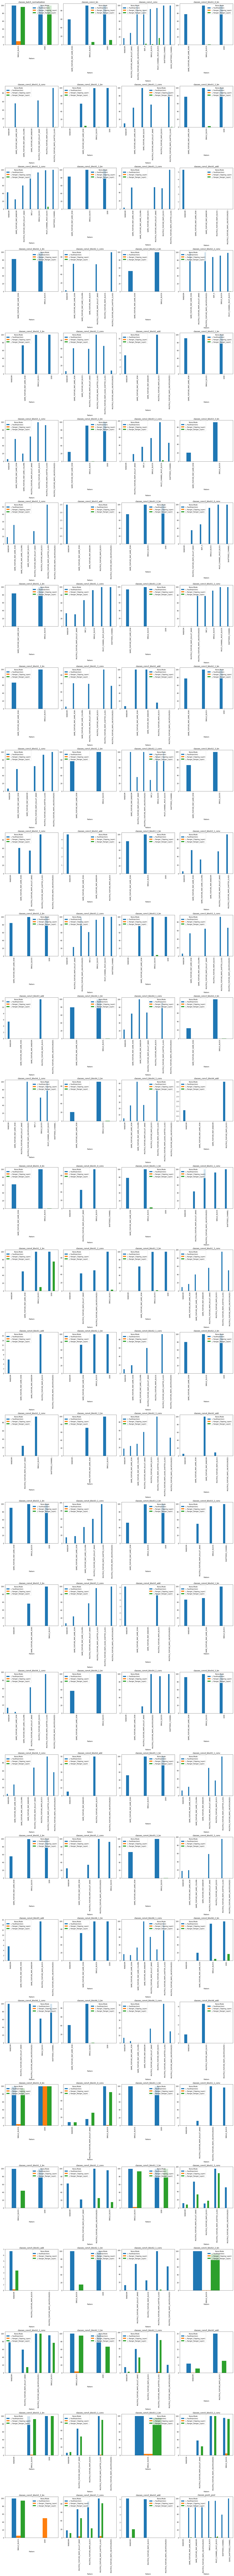

In [36]:
import math
N = len(classes_layers)
GRID_X = 4
GRID_Y = math.ceil(N/GRID_X)

fig, axs = plt.subplots( ncols=GRID_X, nrows=GRID_Y, layout='constrained', figsize=(3.5 * 6, 7.5 * GRID_Y))

for x in range(GRID_X):
    for y in range(GRID_Y):
        idx = x + y*GRID_X
        if idx < N:
            title  = classes_layers[idx]
            report = reports[idx]
            report.plot.bar(ax = axs[y,x])
            axs[y,x].set_title(title)